# 01-Creation

Things to do:
1. Initialize root case
    1. take in FASTA file from directory
    2. save FASTA sequence as array of characters
    3. intitialize community, date
2. Create descendent communities
    1. Set number of people in each communitiy
    2. look at SIR rates  - when infected 
        1. infecting x in A - Poisson
        2. infection x in B - Poisson
        3. recovering and leaving R - Gaussian? IDK
        4. select person from each community randomly based on rate
    3. At infection, look at mutation formula and pass onto reciever
    
TODO:
 *  figure out community size x data structure - prob dictionary
 *  how to pick community?
 *  function to actually mutate sequence
    

# 0. Setup

In [84]:
import numpy as np
import scipy.stats as stats
import scipy.special as ssp
import matplotlib as plt
import pandas as pd
import random
import datetime

from Bio import SeqIO


In [85]:
np.random.binomial(99,.25)

15

## 0.1 Functions

In [280]:
#from functions import num_infected
def num_infected(rate, Sus_I):
#inner beta, intra beta, arrays of indices for inside and outside group
#returns: arrays of index numbers for those selected
    I_inf = []

    
    num_in = int(np.random.poisson(rate))
    #print('num in: ' + str(num_in))
    #print('num out: ' + str(num_out))
    
    for i in range(num_in):
        if len(Sus_I) == 0:
            break
        I_inf.append(random.choice(Sus_I))
    return I_inf
                     


In [245]:
#==============================================================================
# mutation https://www.nature.com/articles/s41467-020-19818-2 - clock rate
#==============================================================================

def agent_mut_num(rate=0.419):
#adds mutationfor every 3 transmissions
#returns: number of mutations
    mymut = np.random.poisson(rate)
    return mymut


def spot_mutation(num, seq):
#one mutation for every 2-3 transmissions
#returns: new sequence
    conversion = ['A', 'C', 'T', 'G']
    swap = random.sample(range(len(s)), 3)
    for i in swap:
        spot = seq[i]
        smaller = conversion[conversion != spot]
        seq[i] = random.choice(smaller)
    return seq

In [237]:
s =allseq[1000]

In [242]:
random.sample(range(len(s)), 3)

[13443, 27239, 11159]

In [177]:
#==============================================================================
# recovery 
#==============================================================================

def recovery_odds(k=1,theta=10):
#gamma functoin - time until next event
                     #k is number of events (one)
                     #theta is avg num days to infection (10)
#returns: time in days until recovery. save and then check if infection day is higher than that
    day = round(np.random.gamma(k, theta, 1)[0])
    return day

In [86]:
base = SeqIO.to_dict(SeqIO.parse('data/reference.fasta', 'fasta'))
ref= base['base_case']
refseq = np.array(ref)

## 0.2 Time Steps
* chosing to run for 31 days
* [equation](https://cse.cs.ucsb.edu/sites/default/files/publications/NewTau052.pdf)  for determining Tau: IGNORING ME - ASK IN GROUP MEETING

In [157]:
times = np.arange(0,31)


In [263]:
allseq = {}

# 1. Initializing Cases/Agents

### 1.1 Community Stat
    start initalize all communities and starting state of susceptible

In [299]:
char = ['accession','community','state','infection_date','index_ID','descendants', 'recovery']
agents = pd.DataFrame(columns=char, index=range(100))

agents['state'] = 'S'
    #initiialize all as Susceptible - 'S'
agents['community'] = np.random.binomial(1,0.5,100) 
    #random 50/50 to be in community A vs B. multinomial if more communitis
#agents['community'] = [ chr(x+65) for x in agents.community]
    #convert numerical binomial to char. 0 - A, 1- B...///////////
agents['descendants'] = [[]] * agents.shape[0]
    
#don't need to save sequence here, save to dict w key as accession

In [300]:
agents

,accession,community,state,infection_date,index_ID,descendants,recovery
0,NaN,1,S,NaN,NaN,[],NaN
1,NaN,1,S,NaN,NaN,[],NaN
2,NaN,0,S,NaN,NaN,[],NaN
3,NaN,1,S,NaN,NaN,[],NaN
4,NaN,0,S,NaN,NaN,[],NaN
...,...,...,...,...,...,...,...
95,NaN,0,S,NaN,NaN,[],NaN
96,NaN,1,S,NaN,NaN,[],NaN
97,NaN,1,S,NaN,NaN,[],NaN
98,NaN,1,S,NaN,NaN,[],NaN


### 1.2 Initial I

In [301]:
agents.at[0, 'accession'] = int(1000)
agents.at[0, 'state'] = 'I'
agents.at[0, 'infection_date'] = datetime.date.fromisoformat('2020-03-01')
k =  round(np.random.exponential(10))
agents.at[0,'recovery'] = datetime.date.fromisoformat('2020-03-01') + datetime.timedelta(days=k)
allseq[agents.iloc[0].accession] = refseq 
agents


,accession,community,state,infection_date,index_ID,descendants,recovery
0,1000,1,I,2020-03-01,NaN,[],2020-03-02
1,NaN,1,S,NaN,NaN,[],NaN
2,NaN,0,S,NaN,NaN,[],NaN
3,NaN,1,S,NaN,NaN,[],NaN
4,NaN,0,S,NaN,NaN,[],NaN
...,...,...,...,...,...,...,...
95,NaN,0,S,NaN,NaN,[],NaN
96,NaN,1,S,NaN,NaN,[],NaN
97,NaN,1,S,NaN,NaN,[],NaN
98,NaN,1,S,NaN,NaN,[],NaN


### 1.3 Infection

In [302]:
for day in times:
    step = int(day)
    hoy = datetime.date.fromisoformat('2020-03-01') + datetime.timedelta(days=step)
    sus = agents[agents.state=="S"]
    inf = agents[agents.state=="I"]
    
    for ii in inf.T:
        print(ii)
        if agents.iloc[ii].recovery == hoy:
            agents.at[ii, 'state'] = 'R'
            break
        com = agents.iloc[ii].community
        ins = num_infected(0.3, sus[sus.community==com].index)
        for i in ins:
            ID =  random.randint(1,9999)
            indID = agents.iloc[ii].accession
            agents.at[i, 'accession'] = ID
            agents.at[i, 'state'] = "I"
            agents.at[i, 'infection_date'] = hoy
            agents.at[i, 'index_ID'] = indID
            agents.at[i, 'recovery'] = hoy + datetime.timedelta(days=round(np.random.exponential(10)))
            #agents.at[ii, 'descendants'] = np.append(i) #this is logic is so wrong skskkssk fix
            allseq[ID] = spot_mutation(agent_mut_num, allseq[indID])
            
            
        outs = num_infected(0.15, sus[sus.community!=com].index)
        for o in outs:
            ID =  random.randint(1,9999)
            indID = agents.iloc[ii].accession
            agents.at[o, 'accession'] = ID
            agents.at[o, 'state'] = "I"
            agents.at[o, 'infection_date'] = hoy
            agents.at[o, 'index_ID'] = indID
            agents.at[o, 'recovery'] = hoy + datetime.timedelta(days=round(np.random.exponential(10)))
            #agents.at[ii, 'descendants'] = np.append(o) #this is logic is so wrong skskkssk fix
            allseq[ID] = spot_mutation(agent_mut_num, allseq[indID])
        #print(ins)
        #print(outs)
    print("today " + str(day))
    
    


0
today 0
0
today 1
84
today 2
84
94
today 3
21
84
94
today 4
21
28
31
84
94
today 5
18
21
28
31
34
84
88
89
90
94
today 6
18
21
today 7
18
28
today 8
18
31
34
62
84
88
89
90
today 9
18
today 10
31
34
62
today 11
13
31
34
84
88
89
90
today 12
12
today 13
13
30
31
34
35
37
39
84
88
89
90
today 14
13
30
31
32
34
35
37
39
46
48
59
today 15
10
13
30
31
32
34
35
37
39
46
48
49
63
66
84
today 16
10
13
today 17
10
19
today 18
10
23
today 19
10
30
31
32
34
35
37
39
46
48
49
63
66
67
68
72
73
76
77
79
88
89
90
93
96
today 20
2
5
10
14
today 21
2
5
10
29
30
31
32
33
today 22
2
5
10
22
29
30
31
32
34
35
36
37
38
39
45
46
48
49
51
56
57
60
today 23
2
5
today 24
2
10
22
24
25
29
30
31
32
34
35
36
37
38
39
42
45
46
47
48
49
50
51
56
57
63
66
67
68
today 25
2
3
4
6
8
today 26
2
3
4
today 27
2
3
6
10
17
20
22
24
25
29
30
31
32
34
today 28
1
2
3
6
7
10
16
17
20
22
24
25
26
29
30
31
32
35
36
37
38
39
40
42
44
45
46
today 29
1
2
today 30


In [303]:
agents.accession.describe()

count       90
unique      90
top       5377
freq         1
Name: accession, dtype: int64

In [315]:
agents.index_ID.max()


9887

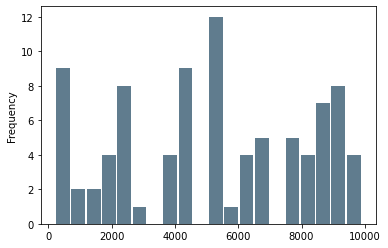

In [322]:
agents.index_ID.plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.ylabel=('Frequency')
plt.xlabel=('Infector')

In [323]:
allseq


{1000: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1287: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1156: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1371: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1776: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1774: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1426: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1637: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1534: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1940: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1930: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1771: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1352: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1779: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1578: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1'),
 1299: array(['A', 'T', 'T', ..., 'A', '